# Projekt 1 – perceptron Rosenblatta

## Temat: płytka sieć do nauki problemu XOR

## Tasks:
### Waiting


* Zaimplelentować mini - batche 

* Wykresy błędu MSE (błędu średniokwadratowego) w obu warstwach (na przykładach uczących oraz na całym zbiorze uczącym):
    - dla warstwy ukrytej MSE
    - dla całego ciągu uczącego 
    - dla przykładu uczącego

* wykresy wag w obu warstwach.



* Dodać opisy zdjęć - skąd są
* ujednolicić nazwy zmiennych

* Opis zaimplementowanych funkcji - dopieścić
* Opis zaimplementowanych zmiennych i stałych - eze


### In progres


### Ready
* szybsze kończenie uczenia przy spadku MSE poniżej zadanej wartości
* wykresy błędu klasyfikacji

### Done
* wykresy błędu klasyfikacji (przyjmujemy próg 0.5 dla klasyfikacji 0-1)
* Krótki opis problemu


<!-- ### To do - jak wystarczy czasu - pewnie nie wystarczy:

* dodanie momentum,
* adaptacyjny współczynnik uczenia,
* dodanie mini-batch. -->



### Opis Problemu - MLP for XOR problem
Problem XOR (Exclusive OR) stanowi kluczowy problem w uczeniu maszynowym, który ilustruje wyzwania związane z tworzeniem modeli opartych na neuronach lub sieciach neuronowych.

XOR to logiczna operacja, która zwraca prawdę (1) tylko wtedy, gdy jedno z wejść jest prawdziwe, a drugie fałszywe.

![Bramka XOR](./photos/XOR_tabela_prawdy.png)


Problem polega na tym, że XOR nie jest liniowo separowalny - oznacza to, że nie można podzielić przestrzeni wejść linią (linią prostą w dwóch wymiarach lub płaszczyzną w trzech wymiarach), aby poprawnie oddzielić przypadki prawdziwe od fałszywych.

![Przestrzeń cech XOR](./photos/XOR_przestrzen_wejsc.png)



Tradycyjne modele liniowe, takie jak regresja logistyczna czy perceptron, nie są w stanie modelować funkcji XOR, ponieważ nie mogą stworzyć odpowiedniego podziału przestrzeni wejść. Jednak sieci neuronowe z warstwą ukrytą potrafią rozwiązać ten problem poprzez tworzenie nieliniowych kombinacji wejść. Wprowadzenie warstwy ukrytej pozwala na stworzenie odpowiednich granic decyzyjnych w przestrzeni cech, umożliwiając modelowi na nauczenie się funkcji XOR.

![Rozwiązanie XOR za pomocą MLP](./photos/rozw_problemuXOR_MLP.png)



W celu sprawnego nauczenia sieci i przedstawienia skondensowanych wyników, sieć domyślnie jest uczona 4 przypadków jednocześnie, tj zbierane są gradienty dla każdego przypdadku wejścia XOR i zmiany dW1, db1, dW2, db2 są wszystkie nakładane jednocześnie.  

In [34]:
import numpy as np
#import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime

In [35]:
plt.rc('font', size=12)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [36]:
now = datetime.now().second # trochę bardziej losowe generowanie seeda
np.random.seed(now) # on był pseudo losowy celowo XD

In [37]:
# generowanie danych na podstawie parametrów podanych przez użytkownika
def data_generator(random = False, is_shuffle = True):
    if random:
        X = np.random.binomial(1, 0.5, (4, 2))
        Y = np.array([[X[i][0] ^ X[i][1]] for i in range(0,X.shape[0])])
    else:
        X = np.array([[0,0],[0,1],[1,0],[1,1]])
        Y = np.array([[0],[1],[1],[0]])     
    if is_shuffle:
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        X = X[indices]
        Y = Y[indices]
    return X, Y

def shuffle(X,Y):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    Y = Y[indices]
    return X,Y

In [38]:
# funkcja aktywacji używana dla każdego neuronu
def sigmoid(x): 
	return 1.0/(1.0 + np.exp(-x))
# pochodna funkcji aktywacji używana przy obliczaniu wag w propagacji wstecznej
def sigmoid_prime(x): 
    return x * (1 - x)

In [39]:
# inicjalizacja wag i baiasów
def initialize_params():
    W1 = np.random.rand(2, 2) - 0.5
    b1 = np.random.rand(1, 2) - 0.5
    W2 = np.random.rand(2, 1) - 0.5
    b2 = np.random.rand(1, 1) - 0.5
    return W1, b1, W2, b2

In [40]:
# funkcja odpowiedzialna za przeprowadzenie obliczeń sieci opartych na wejściu (X) oraz na Wagach(W1,W2) i bajasach (b1,b2)
def forward_prop(W1, b1, W2, b2, X):
    Z1 = np.dot(X,W1) + b1
    A1 = sigmoid(Z1)
    
    Z2 = np.dot(A1,W2) + b2
    A2 = sigmoid(Z2)
    
    return A1, A2

# funkcja przeprowadzająca proces wstecznej propagacji za pomocą której obliczane są gradienty i zmiany jakie muszą być dodane do Wag i bajasów 
def backward_prop(A1, A2, W1, W2, X, Y, lr): 
    dA2 = Y - A2 # Pochodna będu MSE
    dZ2 = dA2 * sigmoid_prime(A2)
    
    dA1 = dZ2.dot(W2.T)
    dZ1 = dA1 * sigmoid_prime(A1) 

    dW1 = lr * X.T.dot(dZ1)
    db1 = lr * np.sum(dZ1,axis=0,keepdims=True)
    dW2 = lr * A1.T.dot(dZ2) 
    db2 = lr * np.sum(dZ2,axis=0,keepdims=True)

    return dW1, db1, dW2, db2


In [41]:
# zwraca błąd klasyfikacji
def classification_error(Y,A2):
    C = np.abs(Y - A2) > 0.5
    return C.sum()/Y.size

In [42]:
# def get_predictions(A2):
### TO DO

# def get_accuracy(predictions, Y):
### TO DO

def gradient_descent(X, Y, lr, iterations, logs = True, batch_size = 2):
    W1, b1, W2, b2 = initialize_params()# funkcja zwraca wagi i bajasy używane w sieci
    SE = []
    CE = []
    MSE = []
    for i in range(iterations):
        A1, A2 = forward_prop(W1, b1, W2, b2, X)# Funkcja zwraca poziomy katywacji dla bydwu warstw
        SE_current = ((Y - A2) ** 2) # liczenie błędu kwadratowego
        MSE.append(np.mean(SE_current))
        SE.append(SE_current)
        dW1, db1, dW2, db2 = backward_prop( A1, A2, W1, W2, X, Y, lr)
        W1 = W1 + dW1
        b1 = b1 + db1 
        W2 = W2 + dW2 
        b2 = b2 + db2
        CE.append(classification_error(Y,A2))
        if i % 1000 == 0 and logs:
            print("Iteration: ", i)
            print(A2.T)
            print(Y.T)
    print("Final Predictions")
    print(A2.T)
    print(Y.T)
    return W1, b1, W2, b2, CE, MSE, SE

In [43]:
X, Y = data_generator(random = False, is_shuffle = False)
W1, b1, W2, b2, CE, MSE, SE = gradient_descent(X, Y, 1, 30000, logs = False)

Final Predictions
[[0.00654109 0.99250241 0.99382971 0.00585765]]
[[0 1 1 0]]


### Błąd klasyfikacji CE

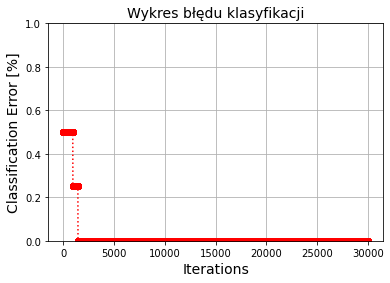

In [44]:
plt.plot(CE,'o:r')
plt.xlabel('Iterations')
plt.ylabel('Classification Error [%]')
plt.ylim([0, 1])
plt.title('Wykres błędu klasyfikacji')
plt.grid(True)
plt.show()

### Błąd średniokwadratowy MSE

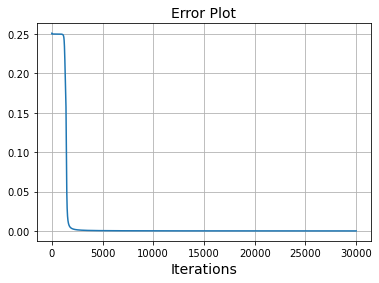

In [45]:
plt.plot(MSE)

plt.xlabel('Iterations')
plt.ylabel('')
plt.title('Error Plot')
plt.grid(True)
plt.show()
